In [18]:
import os
import numpy as np
import polars as pl
import joblib
import pymovements as pm
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
from sklearn import metrics
import shap
import preprocessing.feature_extraction as feature_extraction
import train_classification_model as train_classification_model
import config.config as config
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
shap.initjs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# params
dataset_name = 'gazebase'
label_column = 'task_name'
save_dir = 'results/'
detection_method = 'ivt'
minimum_duration = 100
dispersion_threshold = 1.0
velocity_threshold = 10.0

In [3]:
result_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(save_dir) for f in filenames if (os.path.splitext(f)[1] == '.csv'\
                                and dataset_name in f and label_column in f and detection_method in f\
                                and 'minimum_duration' in f and 'velocity_threshold' in f)]

# get best results
best_f = None
best_s = 0.0
for f in result_files:
    result_pl = pl.read_csv(f)
    mean_res = np.mean(list(result_pl['acc']))
    if mean_res > best_s:
        best_s = mean_res
        best_f = f
print(best_f)

results/gazebasevr_task_name_ivt_minimum_duration_300_velocity_threshold_40.0.csv


In [4]:
minimum_duration = int(best_f.split('_')[6])
velocity_threshold = float(best_f.split('_')[9].replace('.csv',''))
print(minimum_duration)
print(dispersion_threshold)

300
1.0


In [5]:
# detection method params
if detection_method == 'ivt':
    detection_params = {'minimum_duration': minimum_duration,
                        'velocity_threshold': velocity_threshold,
                    }
elif detection_method == 'idt':
    detection_params = {'minimum_duration': minimum_duration,
                        'dispersion_threshold': dispersion_threshold,
                    }
elif detection_method == 'microsaccades':
    detection_params = {'minimum_duration': minimum_duration,
                    }

detection_param_string = ''
for key in detection_params:
    detection_param_string += str(key) + '_' + str(detection_params[key]) + '_'
detection_param_string = detection_param_string[0:len(detection_param_string)-1]

In [6]:
# load config data    
event_name_dict = config.event_name_dict
event_name_code_dict = config.event_name_code_dict
detection_method_default_event = config.detection_method_default_event
feature_aggregations = config.feature_aggregations
blink_threshold = config.blink_threshold
blink_window_size = config.blink_window_size
blink_min_duration = config.blink_min_duration
blink_velocity_threshold = config.blink_velocity_threshold

# small grid
param_grid={
        'n_estimators': [1000],
        'max_features': ['sqrt'],
        'max_depth': [None],
        'criterion': ['entropy'],
        'n_jobs': [-1],
    }
grid_search_verbosity = config.grid_search_verbosity
n_splits = config.n_splits

In [7]:
label_grouping = config.GAZEBASE_LABEL_GROUPING
instance_grouping = config.GAZEBASE_INSTANCE_GROUPING
splitting_criterion = config.GAZEBASE_SPLITTING_CRITERION
max_len = config.GAZEBASE_MAXLEN

dataset = pm.Dataset("GazeBase", path='data/GazeBase')
try:
    dataset.load(subset = {#'subject_id':[1,2,3,4,5,6,7,8,9,10],
                           'task_name': ['BLG', 'FXS', 'HSS', 'RAN', 'TEX', 'VD1'],
                           'round_id': [1],
                           'session_id': [1],
                          })
except:
    dataset.download()
    dataset.load(subset = {#'subject_id':[1,2,3,4],
                           'task_name': ['BLG', 'FXS', 'HSS', 'RAN', 'TEX', 'VD1'],
                           'round_id': [1],
                           'session_id': [1],
                          })

if max_len is not None:
    print('### Cut Sequences ###')
    # cut sequences to max_len
    for i in tqdm(np.arange(len(dataset.gaze))):
        dataset.gaze[i].frame = dataset.gaze[i].frame[0:max_len,:]

sampling_rate = dataset.definition.experiment.sampling_rate
# transform positional data to velocity data
dataset.pos2vel()

# detect events
dataset.detect(detection_method, **detection_params)

# create features
feature_matrix, group_names, splitting_names, feature_names = train_classification_model.get_feature_matrix_parallel(dataset,
                        sampling_rate,
                        blink_threshold,
                        blink_window_size,
                        blink_min_duration,
                        blink_velocity_threshold,
                        feature_aggregations,
                        detection_method,
                        label_grouping,
                        instance_grouping,
                        splitting_criterion,
                        max_len,
                        return_feature_names=True,
                        )

from sklearn.preprocessing import LabelEncoder
label_names = np.array(group_names)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(label_names)                
subjects = np.array(splitting_names)

  0%|          | 0/1932 [00:00<?, ?it/s]

### Cut Sequences ###


100%|█████████████████████████████████████| 1932/1932 [00:00<00:00, 2068.49it/s]


  0%|          | 0/1932 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  ##  Create instances  ##


100%|███████████████████████████████████████| 1932/1932 [00:21<00:00, 90.78it/s]


  ##  Extract features  ##


100%|███████████████████████████████████████████| 49/49 [01:07<00:00,  1.38s/it]


In [8]:
y = np.array(y)
print(' === Evaluating model ===')
print(' === Number of subjects: ' + str(len(np.unique(subjects))) + ' === ')
# split by subjects
group_kfold = GroupKFold(n_splits=n_splits)
aucs = []
accs = []
for i, (train_index, test_index) in enumerate(group_kfold.split(feature_matrix, y, subjects)):
    X_train = feature_matrix[train_index]
    y_train = y[train_index]
    X_test = feature_matrix[test_index]
    y_test = y[test_index]
    
    X_train[np.isnan(X_train)] = 0
    X_test[np.isnan(X_test)]   = 0
    
    # rf
    rf = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=param_grid, verbose=grid_search_verbosity,
    )
    rf.fit(X_train, y_train)

    best_parameters = rf.best_params_
    pred_proba = rf.predict_proba(X_test)
    predictions = rf.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    break

 === Evaluating model ===
 === Number of subjects: 322 === 


In [9]:
explainer = shap.TreeExplainer(rf.best_estimator_)

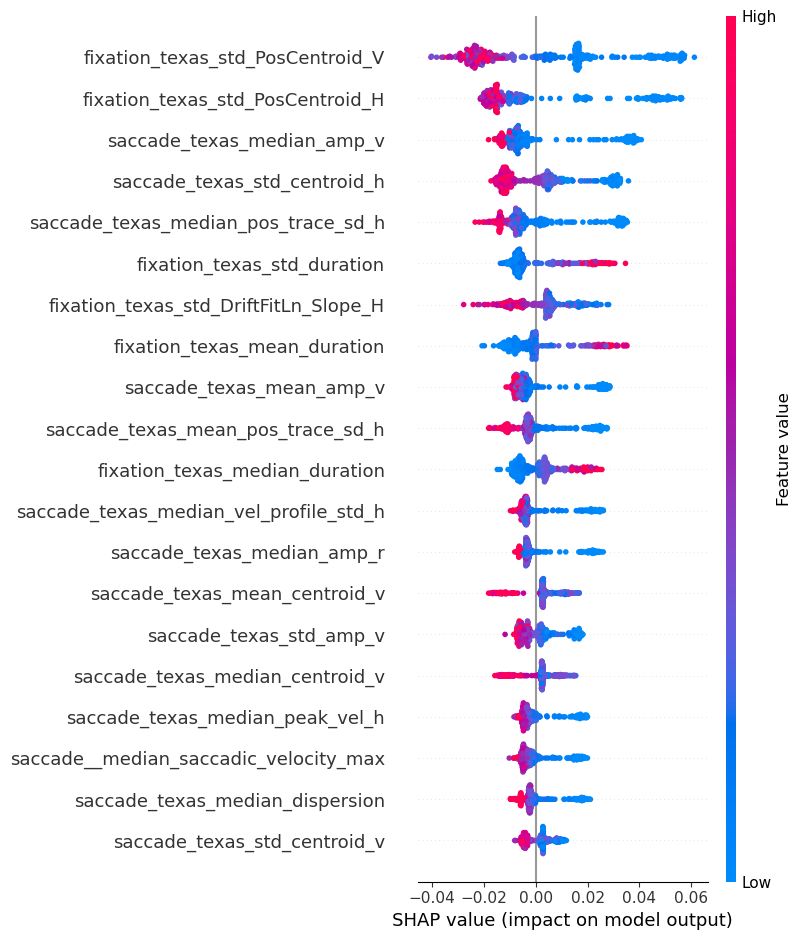

In [10]:
shap_values = explainer.shap_values(X_test, approximate=False, check_additivity=False)
shap.summary_plot(shap_values[:,:,1], X_test, feature_names=feature_names)

In [25]:
human_feature_names_df = pl.read_csv('data/human_readable_features.csv')
human_feature_names_df
f_names_df = list(human_feature_names_df['feature_names'])
h_names_df = list(human_feature_names_df['human_readable'])
f_h_mapping = dict()
for i in range(len(f_names_df)):
    f_h_mapping[f_names_df[i]] = h_names_df[i]
n_feature_names = feature_names.copy()
for i in range(len(n_feature_names)):
    if n_feature_names[i] in f_h_mapping:
        n_feature_names[i] = f_h_mapping[n_feature_names[i]].split('~\cite')[0]

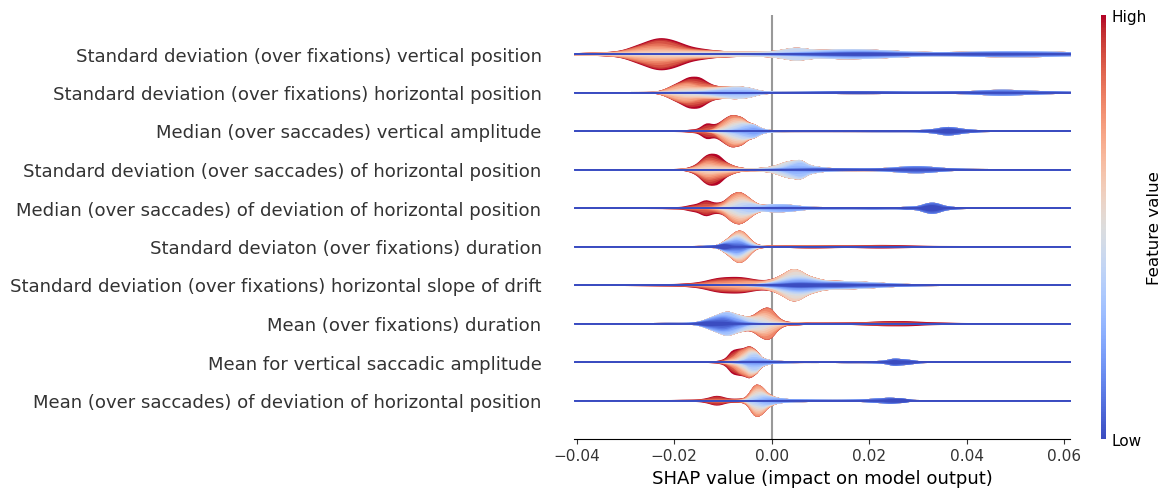

In [26]:
shap.plots.violin(shap_values[:,:,1], features=X_test, feature_names=n_feature_names, plot_type="layered_violin", max_display=10, show=False)
plt.savefig("plots/shap_gazebase_ivt.pdf",dpi=300, bbox_inches='tight')
plt.show()

In [20]:
label_encoder.classes_

array(['BLG', 'FXS', 'HSS', 'RAN', 'TEX', 'VD1'], dtype='<U3')